In [1]:
import xupy as xp
import matplotlib.pyplot as plt

from ekarus.e2e.single_stage_ao_class import SingleStageAO

from ekarus.e2e.utils.image_utils import reshape_on_mask, get_circular_mask

from numpy.ma import masked_array
from ekarus.analytical.zernike_generator import ZernikeGenerator

from arte.math.toccd import toccd


[XuPy] Device 0 available - GPU : `NVIDIA GeForce RTX 4060 Laptop GPU`
       Memory = 7805.56 MB | Compute Capability = 8.9
       Using CuPy 13.5.1 for acceleration.


In [2]:
def imageShow(image2d, pixelSize=1, title='', xlabel='', ylabel='', zlabel='', shrink=1.0):
    sz=image2d.shape
    plt.imshow(image2d, extent=[-sz[0]/2*pixelSize, sz[0]/2*pixelSize,
                                -sz[1]/2*pixelSize, sz[1]/2*pixelSize], cmap='twilight')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cbar= plt.colorbar(shrink=shrink)
    cbar.ax.set_ylabel(zlabel)

def showZoomCenter(image, pixelSize, maxLogValue=None, **kwargs):
    '''show log(image) zoomed around center'''
    imageHalfSizeInPoints= image.shape[0]/2
    roi= [int(imageHalfSizeInPoints*0.8), int(imageHalfSizeInPoints*1.2)]
    imageZoomedLog= xp.log(image[roi[0]: roi[1], roi[0]:roi[1]])
    if maxLogValue is None:
        maxLogValue = xp.max(imageZoomedLog)
    imageZoomedLog -= maxLogValue
    imageShow(xp.asnumpy(imageZoomedLog), pixelSize=pixelSize, **kwargs)

In [3]:
def create_field_from_zernike_coefficients(mask, noll_ids, amplitudes):
    """
    Create an electric field input corresponding to a Zernike aberration.
    
    :param mask: CircularMask object defining the pupil
    :param noll_ids: tuple of Zernike noll number
    :param amplitudes: Amplitude or tuple of amplitudes
                       of the Zernike aberration in radians
    
    :return: input electric field as a numpy complex array
    """
    phase_mask = project_zernike_on_mask(mask, noll_ids, amplitudes)
    return (1-mask) * xp.exp(1j * phase_mask)


def project_zernike_on_mask(mask, noll_ids, amplitudes):
    """
    Create a linear combination of Zernikes on a mask.
    
    :param mask: CircularMask object defining the pupil
    :param noll_ids: tuple of Zernike noll number
    :param amplitudes: Amplitude or tuple of amplitudes
                       of the Zernike aberration in radians
    
    :return: zernike combination
    """
    mask_size = max(mask.shape)
    zg = ZernikeGenerator(xp.asnumpy(mask),mask_size//2)

    if isinstance(noll_ids,int):
        amp = amplitudes
        noll = noll_ids
        zern = amp * xp.asarray(zg.getZernike(int(noll)))
    else:
        amplitudes *= xp.ones_like(noll_ids)
        zern = xp.zeros(mask.shape)
        for amp,noll in zip(amplitudes, noll_ids):
            zern += amp * xp.asarray(zg.getZernike(int(noll)))

    return zern

In [4]:
ssao = SingleStageAO(tn='single_stage_8m')
ssao.initialize_turbulence()
# ssao.pyr.set_modulation_angle(ssao.sc.modulationAngleInLambdaOverD)
# KL, m2c = ssao.define_KL_modes(ssao.dm, zern_modes=5)
# Rec, IM = ssao.compute_reconstructor(ssao.sc, KL, ssao.pyr.lambdaInM, amps=0.002)

Initializing devices ...
Fried parameter is: 10.0 [cm]


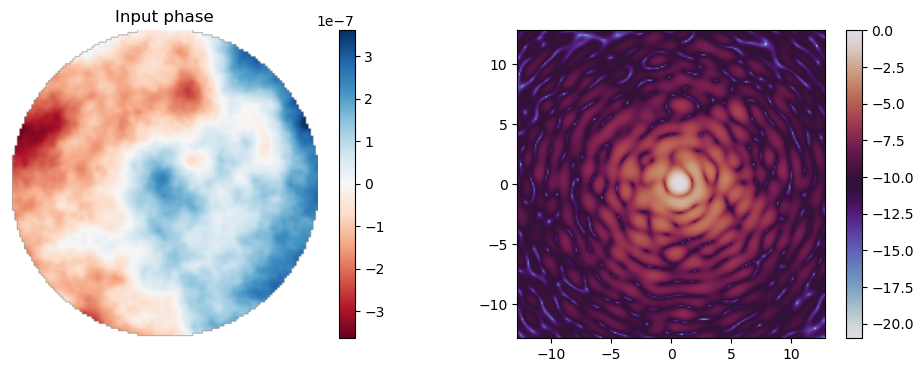

In [5]:
atmo_phase = ssao.get_phasescreen_at_time(0.2)/10
atmo_phase -= xp.mean(atmo_phase[~ssao.cmask])

res_phase = atmo_phase[~ssao.cmask]
lambdaRef = ssao.pyr.lambdaInM
m2rad = 2*xp.pi/lambdaRef

oversampling = 8
field = (1-ssao.cmask) * xp.exp(1j*atmo_phase*m2rad)
padded_field = xp.pad(field, int((oversampling-1)/2*ssao.pupilSizeInPixels), mode='constant', constant_values=0.0)
fp_field = xp.fft.fftshift(xp.fft.fft2(padded_field))
psf = xp.abs(fp_field)**2

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.imshow(masked_array(xp.asnumpy(atmo_phase),mask=xp.asnumpy(ssao.cmask)),origin='lower',cmap='RdBu')
plt.colorbar()
plt.title('Input phase')
plt.axis('off')
plt.subplot(1,2,2)
# plt.imshow(xp.asnumpy(xp.log(psf)-xp.max(xp.log(psf))),origin='lower',cmap='twilight')
# plt.colorbar()
# plt.title('PSF (logscale)')
showZoomCenter(psf,1/oversampling)

In [6]:
# phase_2d = reshape_on_mask(res_phase, pup_mask)
# # phase_var = xp.sum((res_phase-xp.mean(res_phase))**2) 
# phase_var = reshape_on_mask((res_phase-xp.mean(res_phase))**2, pup_mask)
# perfect_coro_field = field_amp * (xp.sqrt(xp.exp(-phase_var))-xp.exp(1j*phase_2d))
# coro_focal_plane_ef = xp.fft.fftshift(xp.fft.fft2(perfect_coro_field))
# coro_psf = abs(coro_focal_plane_ef)**2

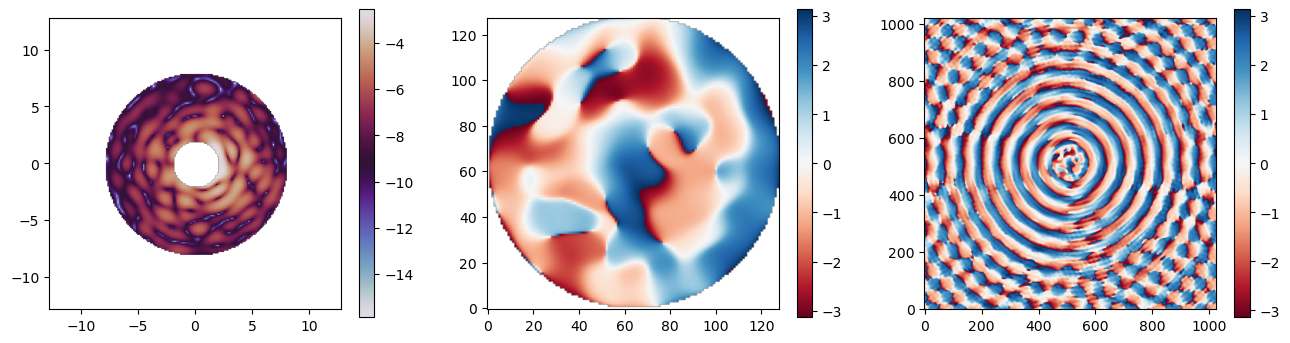

In [7]:
# acts across pupil diameter: N = 32
# IWA = 2 lambda/D
# OWA = N/2 lambda/D
iwa_mask = get_circular_mask(psf.shape, mask_radius=oversampling*2)
owa_mask = get_circular_mask(psf.shape, mask_radius=oversampling*8)
dcd_mask = xp.logical_xor(iwa_mask,owa_mask)

masked_psf = dcd_mask * psf


pupil_dcd = xp.fft.ifft2(xp.fft.ifftshift(fp_field*dcd_mask))
pupil = pupil_dcd[fp_field.shape[0]//2-ssao.pupilSizeInPixels//2:fp_field.shape[0]//2+ssao.pupilSizeInPixels//2,
                  fp_field.shape[1]//2-ssao.pupilSizeInPixels//2:fp_field.shape[1]//2+ssao.pupilSizeInPixels//2]
# pupil = toccd(pupil_dcd,ssao.cmask.shape)
dm_phase = xp.angle(pupil)/m2rad
dm_cmd = ssao.dm.R @ dm_phase[~ssao.cmask]
dm_shape = ssao.dm.IFF @ dm_cmd

plt.figure(figsize=(16,4))
plt.subplot(1,3,2)
plt.imshow(masked_array(xp.asnumpy(xp.angle(pupil)),mask=xp.asnumpy(ssao.cmask)),origin='lower',cmap='RdBu')
plt.colorbar()
plt.subplot(1,3,1)
# plt.imshow(xp.asnumpy(xp.log(masked_psf)-xp.max(xp.log(psf))),origin='lower',cmap='twilight')
# plt.colorbar()
showZoomCenter(masked_psf,1/oversampling,maxLogValue=xp.max(xp.log(psf)))
plt.subplot(1,3,3)
plt.imshow(xp.asnumpy(xp.angle(pupil_dcd)),origin='lower',cmap='RdBu')
plt.colorbar()

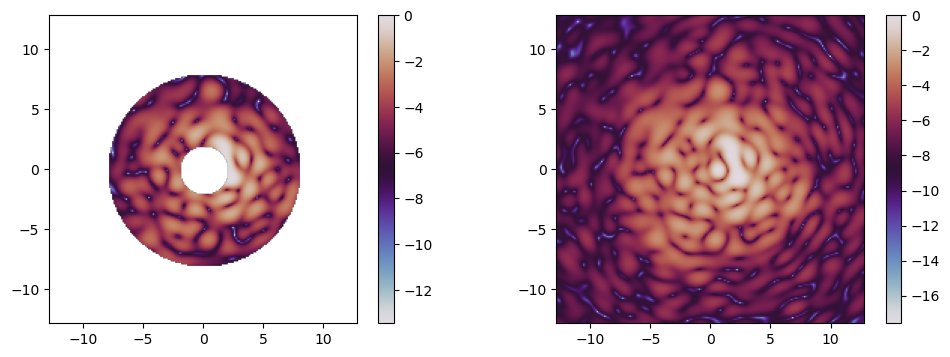

In [8]:
oversampling = 8
field = (1-ssao.cmask) * xp.exp(1j*dm_phase*m2rad)
padded_field = xp.pad(field, int((oversampling-1)/2*ssao.pupilSizeInPixels), mode='constant', constant_values=0.0)
fp_field = xp.fft.fftshift(xp.fft.fft2(padded_field))
psf = xp.abs(fp_field)**2

masked_psf = dcd_mask * psf

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
showZoomCenter(masked_psf,1/oversampling,maxLogValue=xp.max(xp.log(psf)))
plt.subplot(1,2,2)
showZoomCenter(psf,1/oversampling)

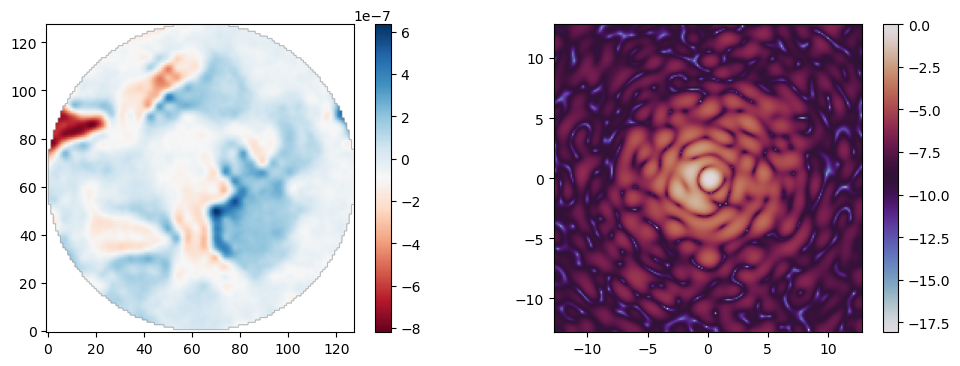

In [9]:
new_phase = res_phase - dm_shape

phase = reshape_on_mask(new_phase, ssao.cmask)

oversampling = 8
field = (1-ssao.cmask) * xp.exp(1j*phase*m2rad)
padded_field = xp.pad(field, int((oversampling-1)/2*ssao.pupilSizeInPixels), mode='constant', constant_values=0.0)
fp_field = xp.fft.fftshift(xp.fft.fft2(padded_field))
psf = xp.abs(fp_field)**2
# crop_psf = psf[fp_field.shape[0]//2-ssao.pupilSizeInPixels:fp_field.shape[0]//2+ssao.pupilSizeInPixels,fp_field.shape[1]//2-ssao.pupilSizeInPixels:fp_field.shape[1]//2+ssao.pupilSizeInPixels]

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.imshow(masked_array(xp.asnumpy(phase),mask=xp.asnumpy(ssao.cmask)),origin='lower',cmap='RdBu')
plt.colorbar()
plt.subplot(1,2,2)
showZoomCenter(psf,1/oversampling)

In [10]:
def improve_contrast(input_phase, cmask, dm, lambdaInM, owa:float, iwa:float=2.0, Nits:int=10, oversampling:int=1, gain:float=0.05):

    m2rad = 2*xp.pi/lambdaInM
    L = max(cmask.shape)
    iwa_mask = get_circular_mask((L*oversampling,L*oversampling), mask_radius=oversampling*iwa)
    owa_mask = get_circular_mask((L*oversampling,L*oversampling), mask_radius=oversampling*owa)
    dcd_mask = xp.logical_xor(iwa_mask,owa_mask)
    top = xp.zeros_like(dcd_mask)
    top[1+(L*oversampling)//2:,:] = 1.0
    dcd_mask *= top

    field_amp = 1-cmask

    # max_dm_stroke_in_rad = 3.0

    dm_phase = xp.zeros(cmask.shape)

    for j in range(Nits):
        print(f'\rIteration {j+1:1.0f}/{Nits:1.0f}',end='\r',flush=True)
        res_phase = input_phase - dm_phase

        field = field_amp * xp.exp(1j*res_phase*m2rad)
        padded_field = xp.pad(field, int((oversampling-1)/2*L), mode='constant', constant_values=0.0)
        fp_field = xp.fft.fftshift(xp.fft.fft2(padded_field))
        psf = xp.abs(fp_field)**2

        # # phase_var = xp.sum((res_phase-xp.mean(res_phase))**2) 
        # phase_var = reshape_on_mask(xp.std(res_phase[~cmask])**2,cmask)
        # perf_coro_field = field_amp * (xp.sqrt(xp.exp(-phase_var))-xp.exp(1j*res_phase))
        # perfect_coro_field = xp.pad(perf_coro_field, int((oversampling-1)/2*L), mode='constant', constant_values=0.0)
        # coro_focal_plane_ef = xp.fft.fftshift(xp.fft.fft2(perfect_coro_field))
        # coro_psf = abs(coro_focal_plane_ef)**2

        masked_psf = dcd_mask * psf

        pupil_dcd = xp.fft.ifft2(xp.fft.ifftshift(fp_field*dcd_mask))
        pupil = toccd(pupil_dcd,cmask.shape)
        # pupil = pupil_dcd[fp_field.shape[0]//2-L//2:fp_field.shape[0]//2+L//2,
        #                 fp_field.shape[1]//2-L//2:fp_field.shape[1]//2+L//2]
        rec_phase = xp.angle(pupil)/m2rad
        dm_cmd = dm.R @ rec_phase[~cmask]
        dm_shape = dm.IFF @ dm_cmd
        dm_phase += gain*reshape_on_mask(dm_shape,cmask)

        # dm_phase_in_rad = dm_phase*m2rad
        # dm_phase *= max_dm_stroke_in_rad/xp.max(abs(dm_phase_in_rad))

        if j < 5 or j >= Nits - 5:
            plt.figure(figsize=(18,4))
            plt.subplot(1,4,1)
            plt.imshow(masked_array(xp.asnumpy(res_phase*m2rad),mask=xp.asnumpy(ssao.cmask)),origin='lower',cmap='RdBu')
            plt.colorbar()
            plt.title('Residual phase')
            plt.axis('off')
            plt.subplot(1,4,2)
            showZoomCenter(psf,1/oversampling,maxLogValue=xp.max(xp.log(psf)))
            plt.subplot(1,4,3)
            plt.imshow(masked_array(xp.asnumpy(dm_phase*m2rad),mask=xp.asnumpy(ssao.cmask)),origin='lower',cmap='RdBu')
            plt.colorbar()
            plt.title('DM phase')
            plt.axis('off')
            plt.subplot(1,4,4)
            showZoomCenter(masked_psf,1/oversampling,maxLogValue=xp.max(xp.log(psf)))

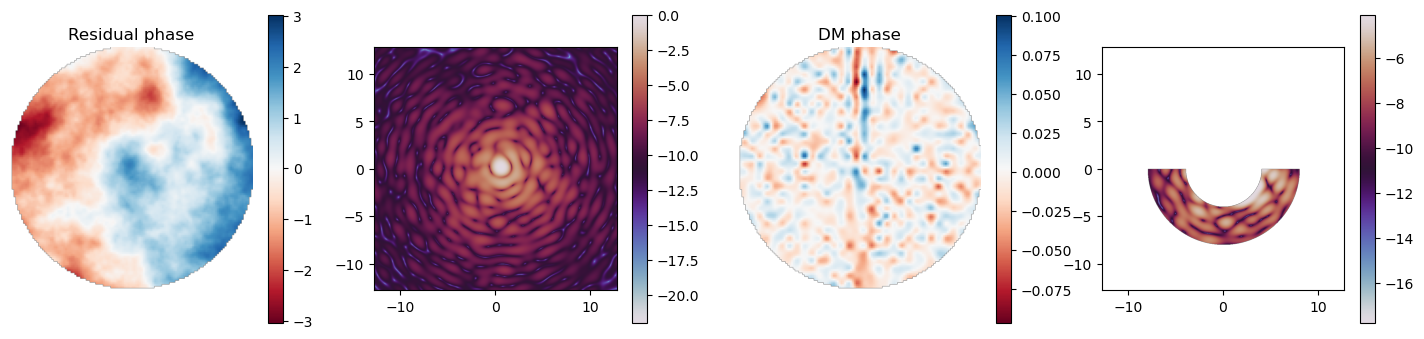

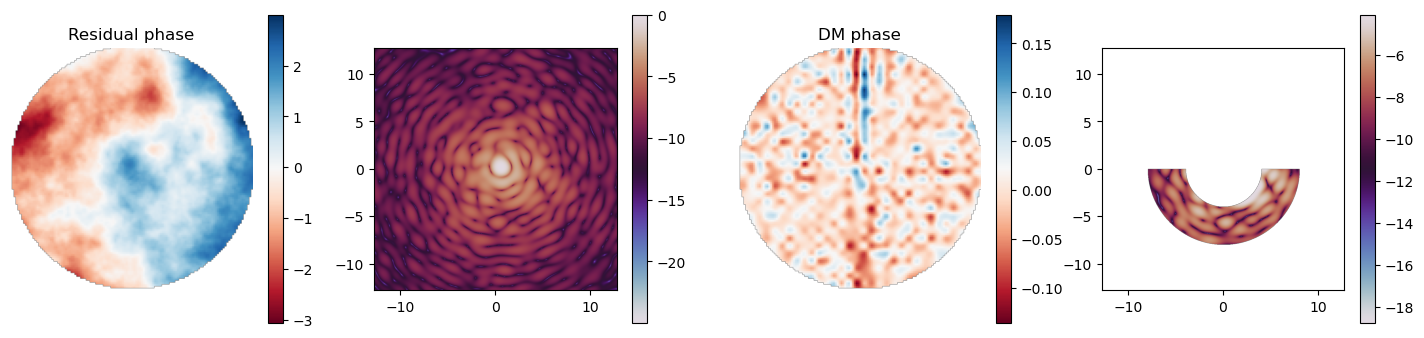

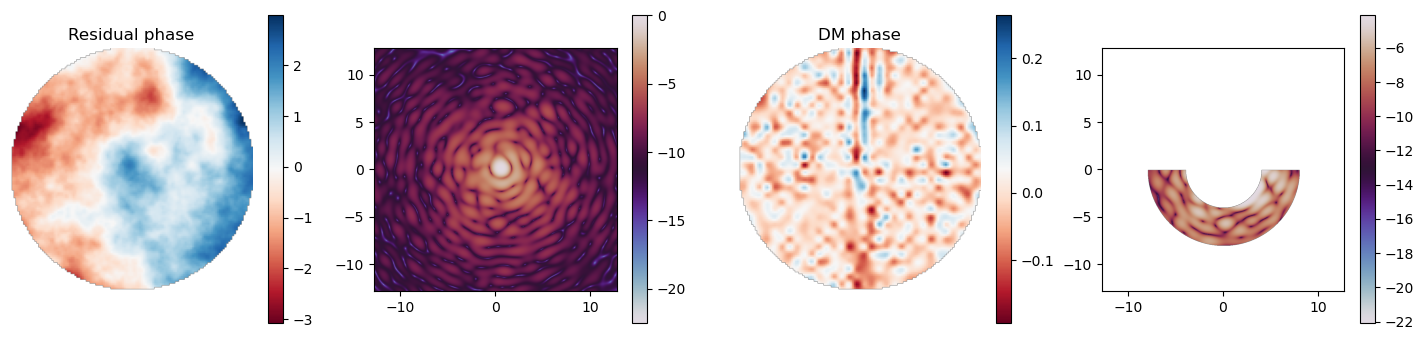

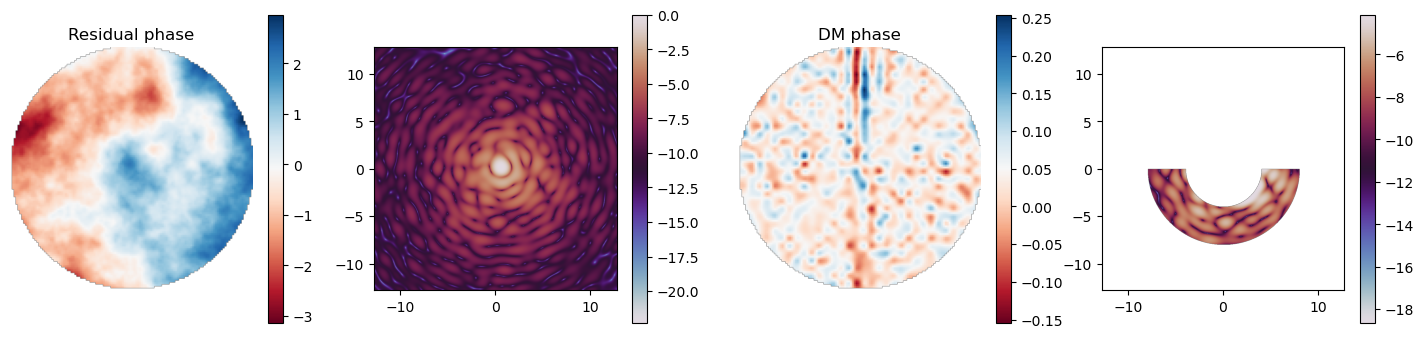

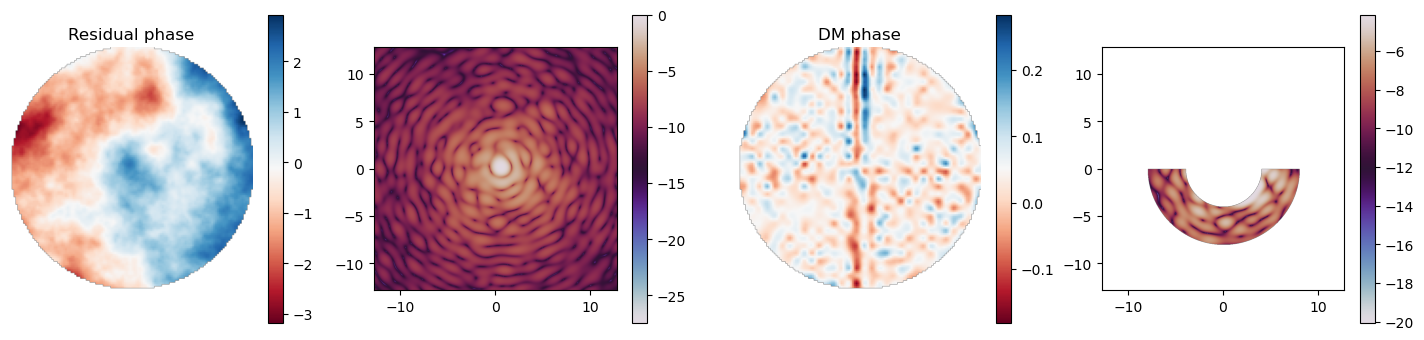

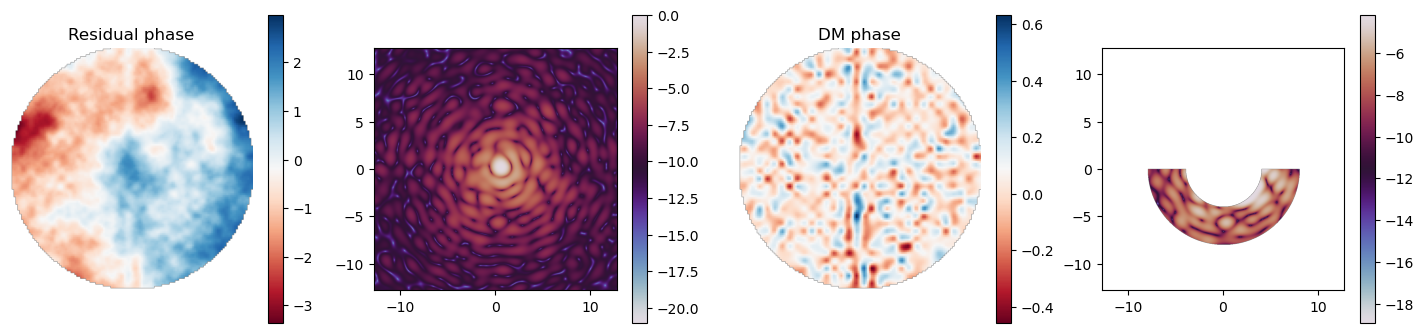

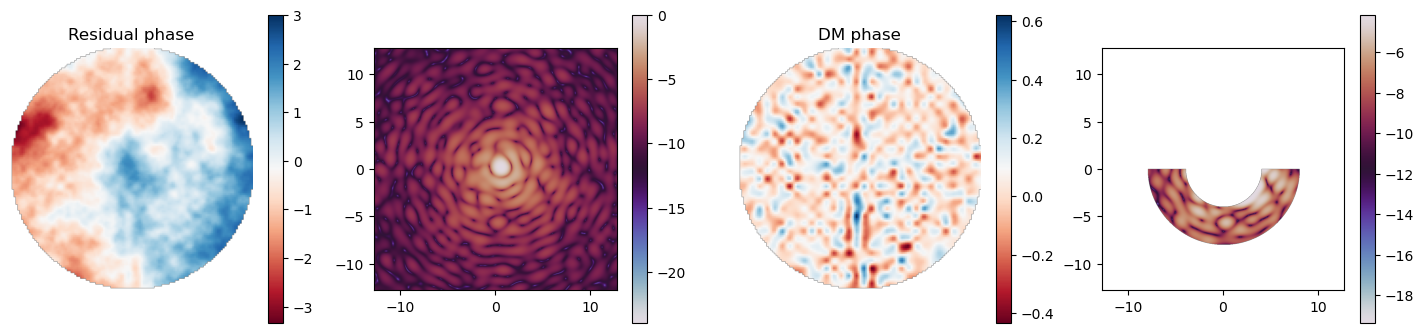

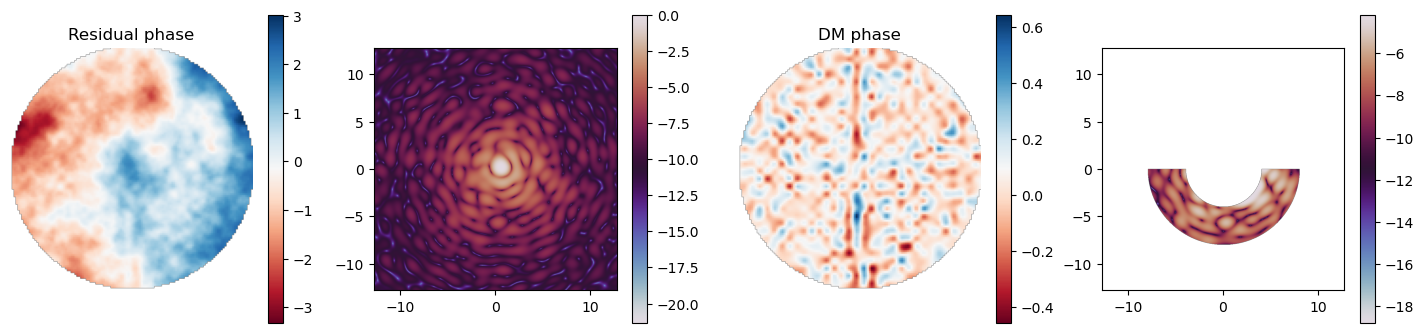

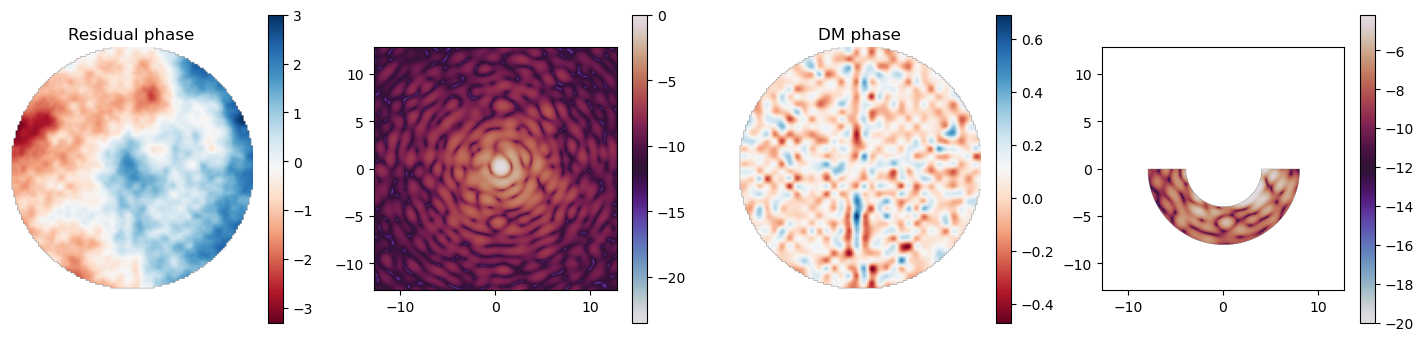

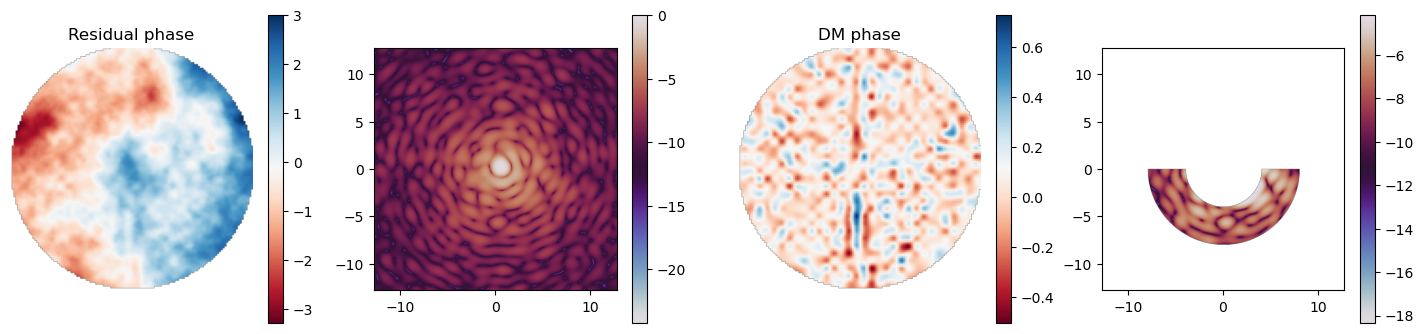

In [11]:
improve_contrast(atmo_phase, ssao.cmask, ssao.dm, lambdaInM=lambdaRef, owa=8, iwa=4, Nits=60, oversampling=32)